File paths and libraries

In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from fsl.wrappers import bet, flirt, fast , fslreorient2std
from skimage import measure

data_dir = ""
bet_dir = ""
flirt_dir = ""
fast_dir = ""
standard_image_path = ""
image_dir = ""
os.makedirs(image_dir, exist_ok=True)

files = [f for f in os.listdir(data_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]
print(f"{len(files)} MRI files:")
for f in files:
    print("-", f)


4 MRI files:
- ADNI_053_S_1044_MR_MPR__GradWarp__B1_Correction__N3_Br_20070910183848883_S33449_I72268.nii
- ADNI_057_S_1379_MR_MPR__GradWarp__B1_Correction__N3_Br_20090514102741022_S66418_I143809.nii
- ADNI_127_S_0393_MR_MPR__GradWarp__B1_Correction__N3_Br_20080123091916004_S22874_I88085.nii
- ADNI_141_S_0767_MR_MPR__GradWarp__B1_Correction__N3_Br_20081028142444542_S57038_I124343.nii


Axial view

In [32]:
def show_axial(file_path, title=None):
    img = nib.load(file_path)
    data = img.get_fdata()
    mid = data.shape[0] // 2
    slice_data = data[mid, :, :]
    plt.imshow(slice_data.T, cmap='gray', origin='lower')
    plt.title(title or "Axial (Z)")
    plt.axis('off')
    plt.show()

Coronal (frontal) view

In [33]:
def show_coronal(file_path, title=None):
    img = nib.load(file_path)
    data = img.get_fdata()
    mid = data.shape[1] // 2
    plt.imshow(data[:, mid, :], cmap='gray')
    plt.title(title or "Coronal (Y)")
    plt.axis('off')
    plt.show()

Saggital view

In [34]:
def show_sagittal(file_path, title=None):
    img = nib.load(file_path)
    data = img.get_fdata()
    mid = data.shape[2] // 2
    slice_data = data[:, :, mid]
    plt.imshow(slice_data.T, cmap='gray', origin='lower')
    plt.title(title or "Sagittal (X)")
    plt.axis('off')
    plt.show()

In [35]:
def show_all_three_views(file_path, base_title=""):
    print(f"Showing views for {os.path.basename(file_path)}")
    show_sagittal(file_path, title=f"{base_title} - Sagittal")
    show_coronal(file_path, title=f"{base_title} - Coronal")
    show_axial(file_path, title=f"{base_title} - Axial")


Showing views for ADNI_053_S_1044_MR_MPR__GradWarp__B1_Correction__N3_Br_20070910183848883_S33449_I72268.nii


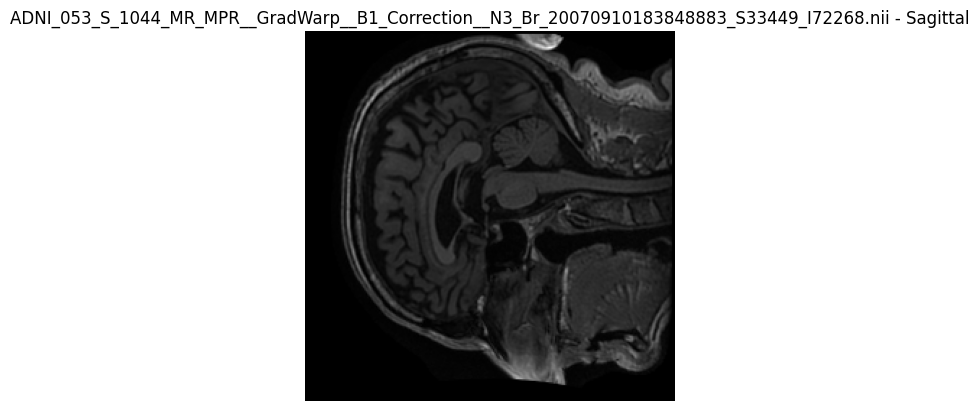

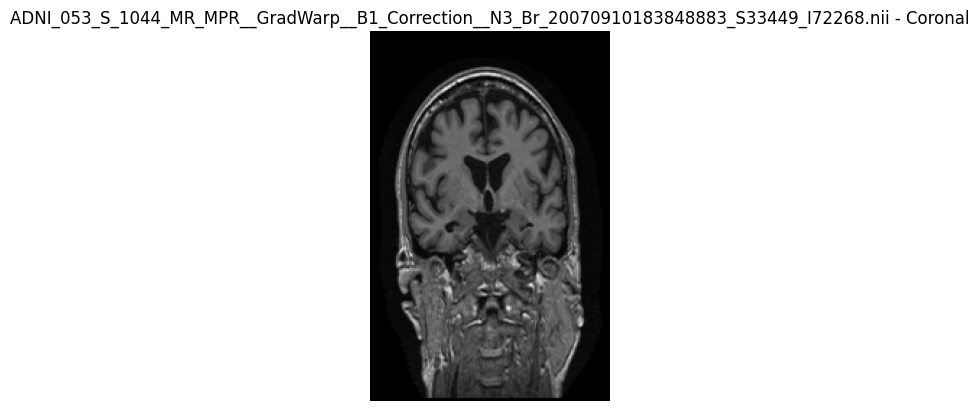

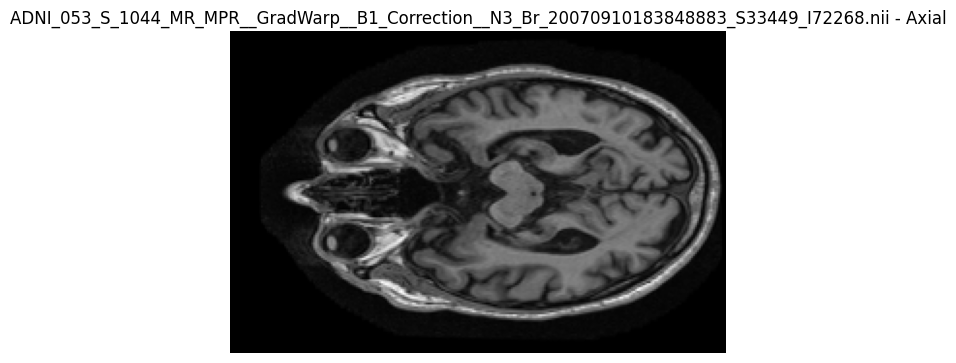

Showing views for ADNI_057_S_1379_MR_MPR__GradWarp__B1_Correction__N3_Br_20090514102741022_S66418_I143809.nii


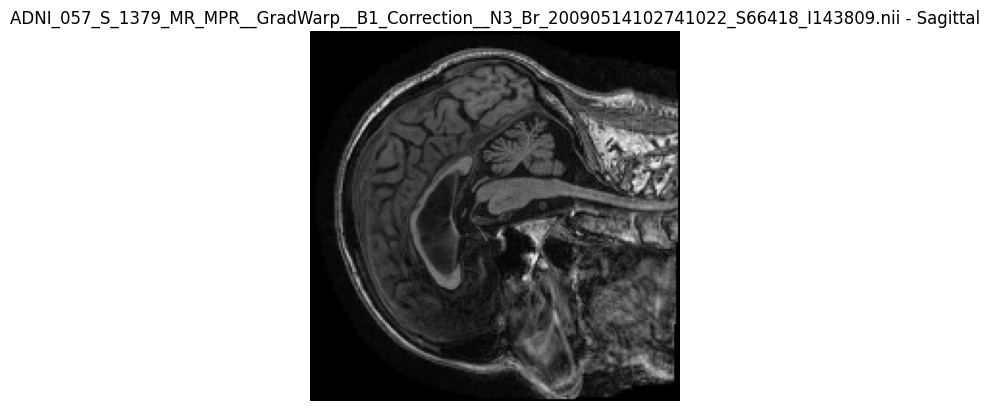

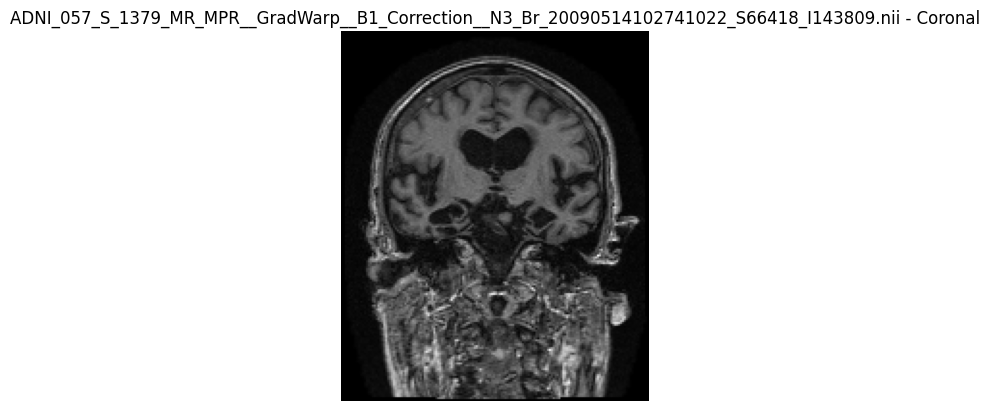

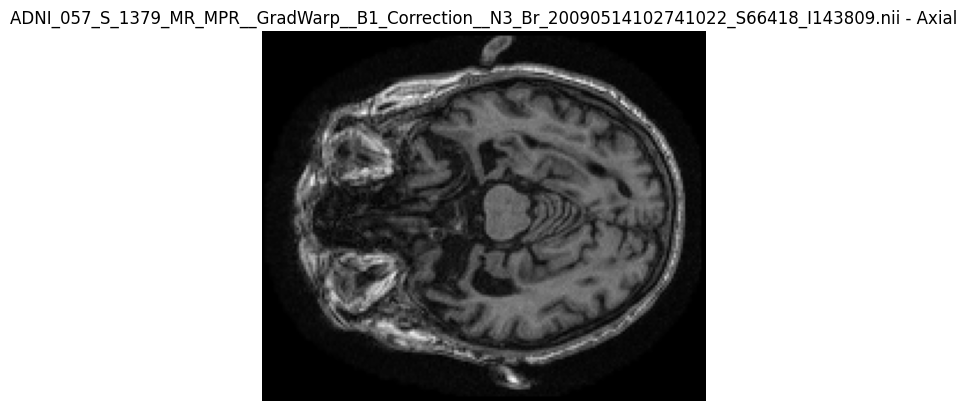

Showing views for ADNI_127_S_0393_MR_MPR__GradWarp__B1_Correction__N3_Br_20080123091916004_S22874_I88085.nii


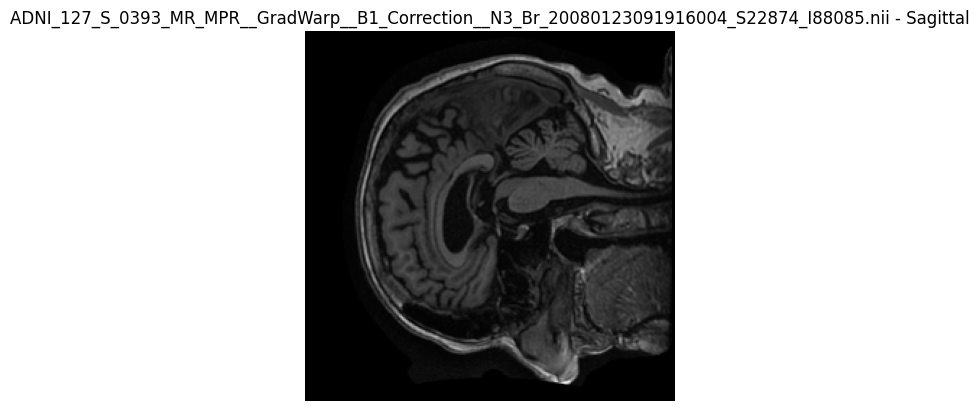

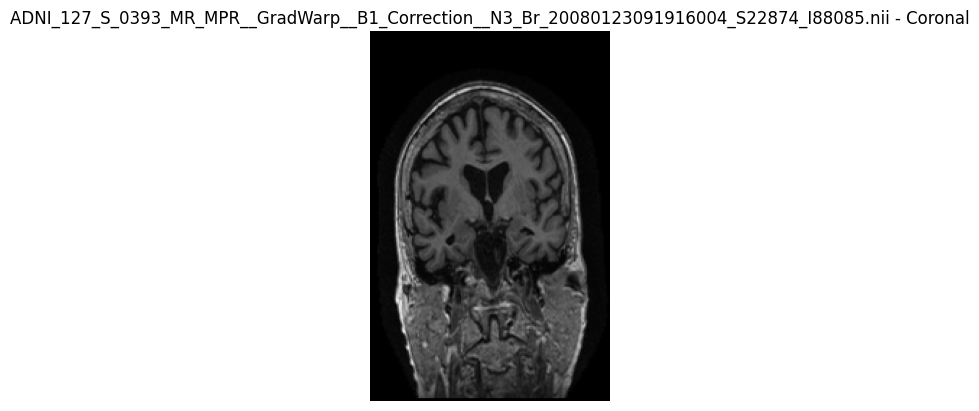

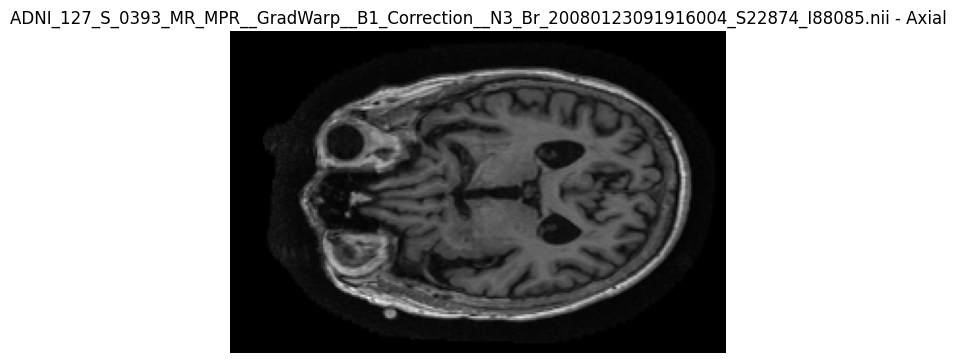

Showing views for ADNI_141_S_0767_MR_MPR__GradWarp__B1_Correction__N3_Br_20081028142444542_S57038_I124343.nii


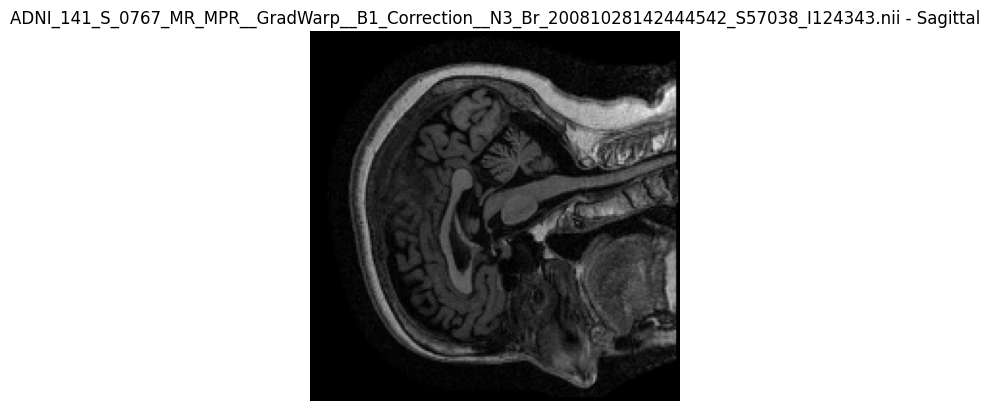

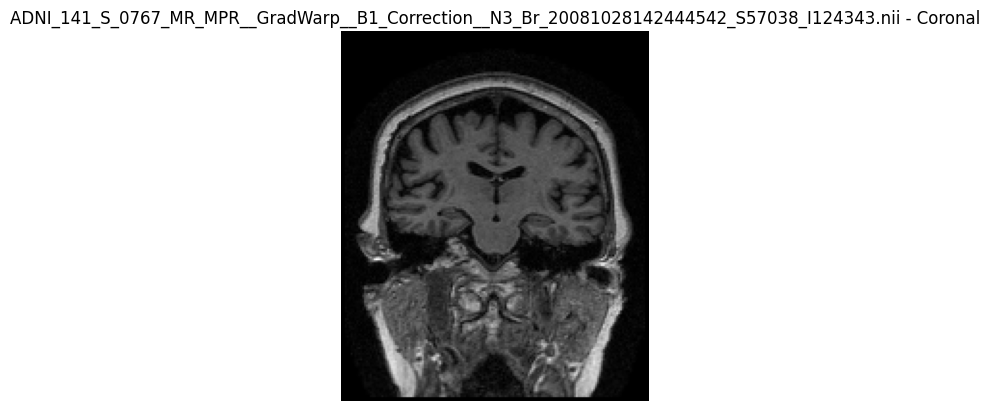

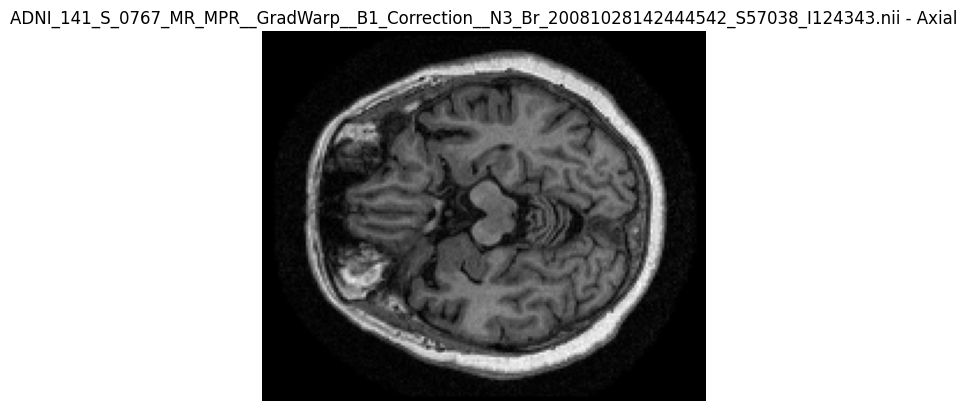

In [36]:
for file in files:
    full_path = os.path.join(data_dir, file)
    show_all_three_views(full_path, base_title=file)


BET interface

In [37]:
from nipype.interfaces.fsl import BET
import subprocess

BET: ADNI_053_S_1044_MR_MPR__GradWarp__B1_Correction__N3_Br_20070910183848883_S33449_I72268.nii


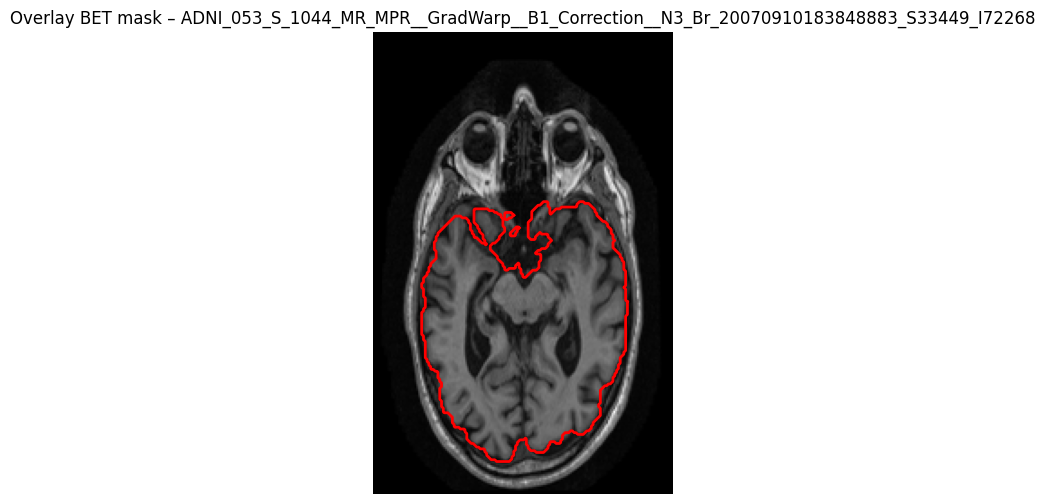

BET: ADNI_057_S_1379_MR_MPR__GradWarp__B1_Correction__N3_Br_20090514102741022_S66418_I143809.nii


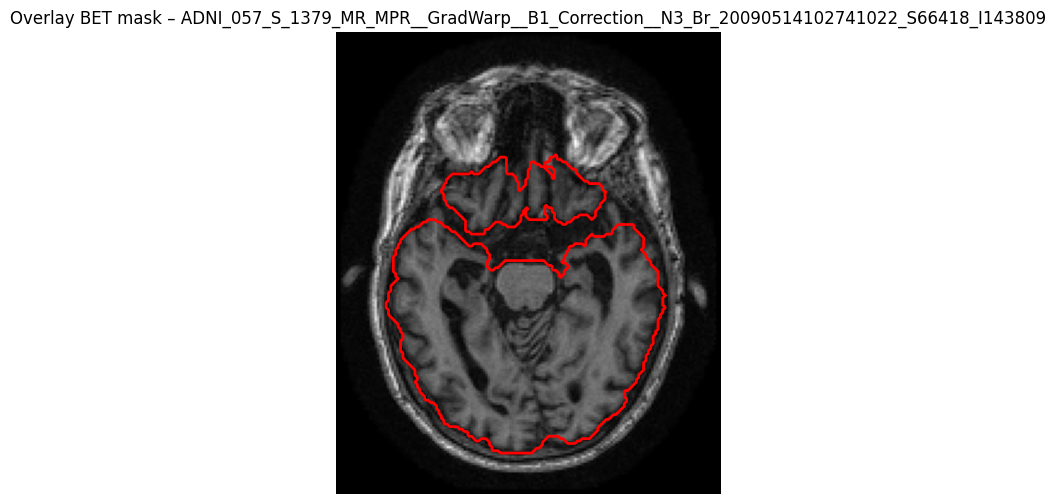

BET: ADNI_127_S_0393_MR_MPR__GradWarp__B1_Correction__N3_Br_20080123091916004_S22874_I88085.nii


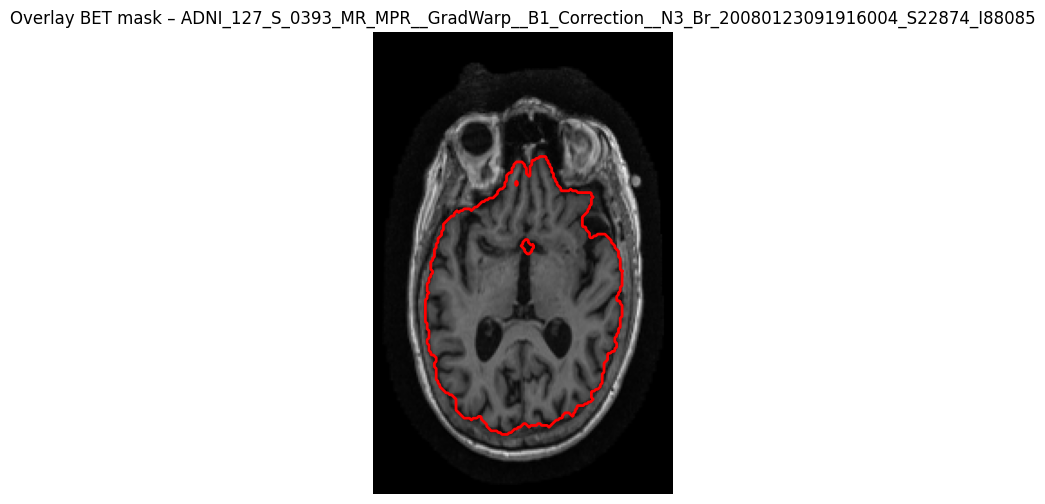

BET: ADNI_141_S_0767_MR_MPR__GradWarp__B1_Correction__N3_Br_20081028142444542_S57038_I124343.nii


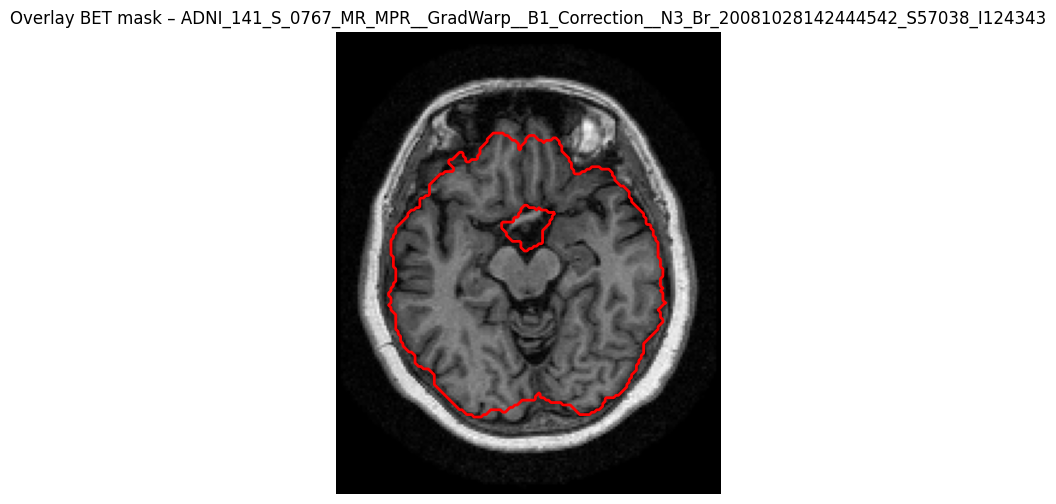

In [38]:
output_dir = bet_dir
os.makedirs(output_dir, exist_ok=True)

for filename in files:
    input_file = os.path.join(data_dir, filename)
    base_name = os.path.splitext(filename)[0]
    if base_name.endswith('.nii'):
        base_name = os.path.splitext(base_name)[0]

    # Reorient to standard using subprocess
    reoriented_file = os.path.join(data_dir, base_name + "_reoriented.nii.gz")
    subprocess.run(["fslreorient2std", input_file, reoriented_file])
    input_file = reoriented_file  

    output_file = os.path.join(output_dir, base_name + "_brain.nii.gz")
    if os.path.exists(output_file):
        os.remove(output_file)

    print(f"BET: {filename}")
    bet(input_file, output_file, f=0.5, g=0, robust=True)

    img_orig = nib.load(input_file).get_fdata()
    img_brain = nib.load(output_file).get_fdata()

    mask = img_brain > 0
    mid_slice = img_orig.shape[2] // 2
    slice_orig = img_orig[:, :, mid_slice]
    slice_mask = mask[:, :, mid_slice]

    contours = measure.find_contours(slice_mask, level=0.5)

    plt.figure(figsize=(6, 6))
    plt.imshow(slice_orig.T, cmap='gray', origin='lower')
    for contour in contours:
        plt.plot(contour[:, 0], contour[:, 1], linewidth=2, color='red')
    plt.title(f"Overlay BET mask – {base_name}")
    plt.axis('equal')
    plt.axis('off')
    plt.show()

FLIRT registration

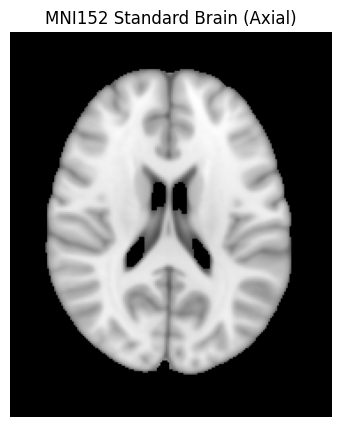

Registering ADNI_053_S_1044_MR_MPR__GradWarp__B1_Correction__N3_Br_20070910183848883_S33449_I72268_brain.nii.gz to MNI space...

Final result: 
1.048609 0.000466 0.046002 -18.503450 
-0.001431 0.966273 0.358142 -35.657857 
-0.035942 -0.408692 1.105918 -24.493237 
0.000000 0.000000 0.000000 1.000000 



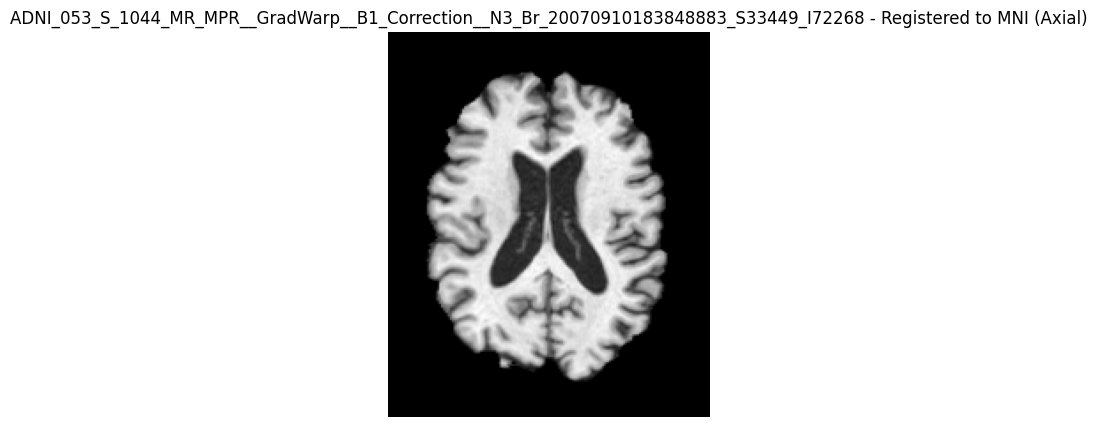

Registering ADNI_057_S_1379_MR_MPR__GradWarp__B1_Correction__N3_Br_20090514102741022_S66418_I143809_brain.nii.gz to MNI space...

Final result: 
1.046911 -0.010169 0.018481 -12.801361 
0.007686 1.009224 0.157706 -23.950843 
0.016145 -0.227922 1.050132 -47.578238 
0.000000 0.000000 0.000000 1.000000 



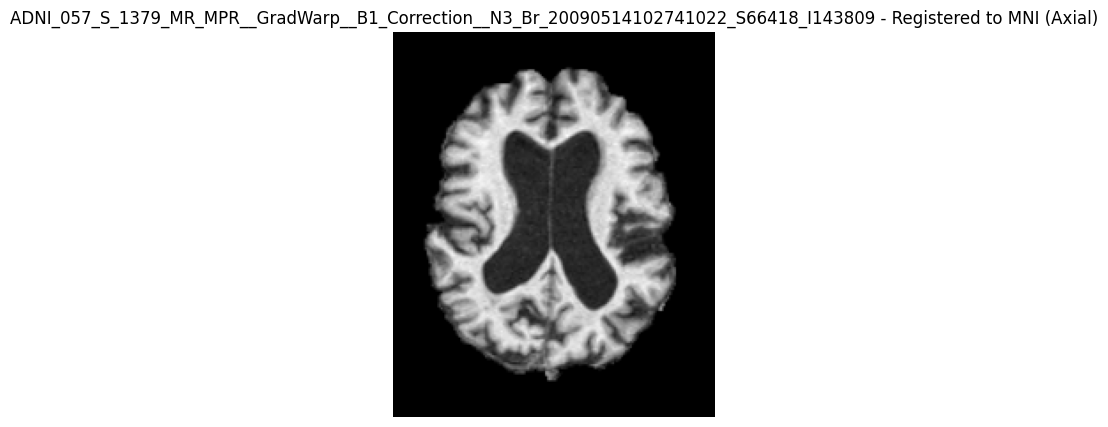

Registering ADNI_127_S_0393_MR_MPR__GradWarp__B1_Correction__N3_Br_20080123091916004_S22874_I88085_brain.nii.gz to MNI space...

Final result: 
1.081604 0.055930 0.071647 -31.188130 
-0.069088 1.068113 0.324445 -35.590513 
-0.061249 -0.457228 1.106002 -6.731679 
0.000000 0.000000 0.000000 1.000000 



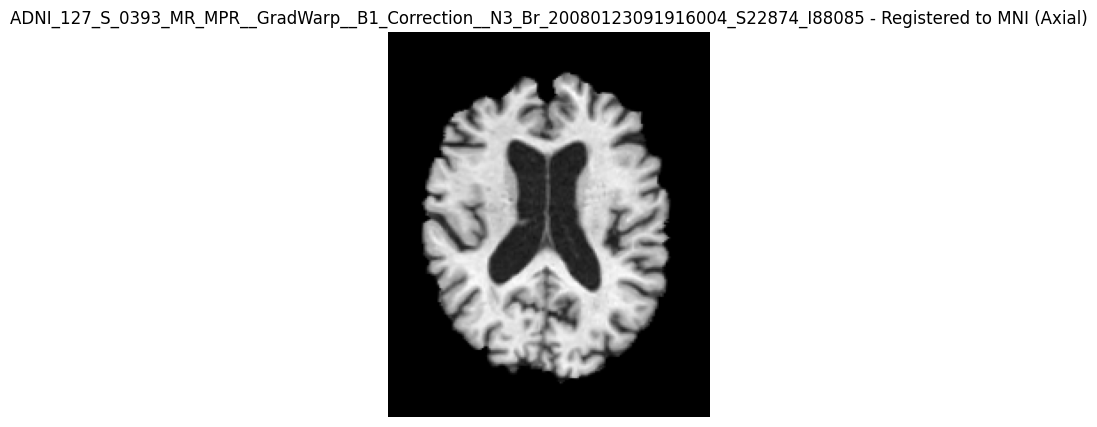

Registering ADNI_141_S_0767_MR_MPR__GradWarp__B1_Correction__N3_Br_20081028142444542_S57038_I124343_brain.nii.gz to MNI space...

Final result: 
1.049409 -0.045716 -0.024965 -2.513371 
0.042565 1.096693 0.140704 -42.455628 
0.064933 -0.156737 1.320639 -87.059866 
0.000000 0.000000 0.000000 1.000000 



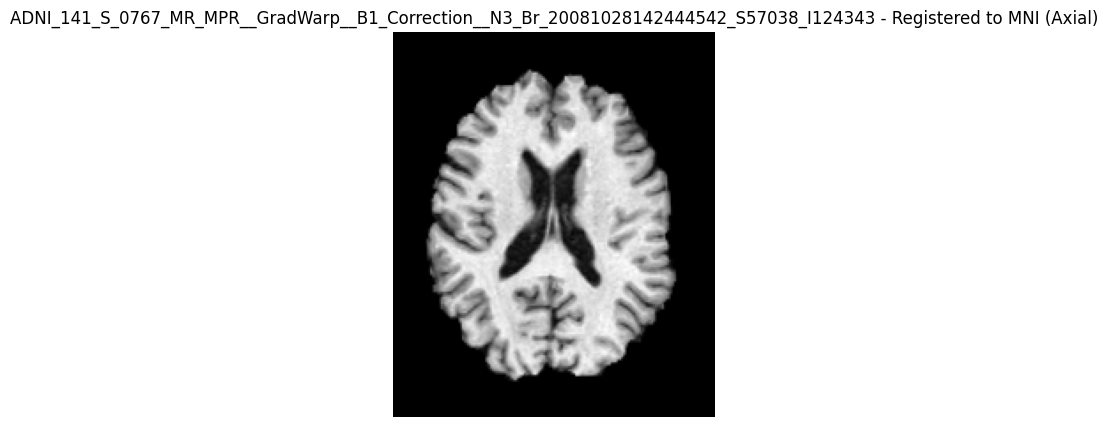

In [39]:
output_dir = flirt_dir
os.makedirs(output_dir, exist_ok=True)

img_mni = nib.load(standard_image_path).get_fdata()
mni_mid = img_mni.shape[2] // 2
mni_slice = img_mni[:, :, mni_mid]

plt.figure(figsize=(5, 5))
plt.imshow(mni_slice.T, cmap='gray', origin='lower')
plt.title("MNI152 Standard Brain (Axial)")
plt.axis('off')
plt.show()

files = [f for f in os.listdir(bet_dir) if f.endswith("_brain.nii.gz")]

for filename in files:
    input_file = os.path.join(bet_dir, filename)
    base_name = filename.replace("_brain.nii.gz", "")
    output_file = os.path.join(output_dir, base_name + "_registered.nii.gz")

    if os.path.exists(output_file):
        os.remove(output_file)

    print(f"Registering {filename} to MNI space...")
    flirt(input_file, standard_image_path, out=output_file)

    img_reg = nib.load(output_file).get_fdata()
    reg_mid = img_reg.shape[2] // 2
    reg_slice = img_reg[:, :, reg_mid]

    plt.figure(figsize=(5, 5))
    plt.imshow(reg_slice.T, cmap='gray', origin='lower')
    plt.title(f"{base_name} - Registered to MNI (Axial)")
    plt.axis('off')
    plt.show()

Running FAST on: ADNI_053_S_1044_MR_MPR__GradWarp__B1_Correction__N3_Br_20070910183848883_S33449_I72268_registered.nii.gz


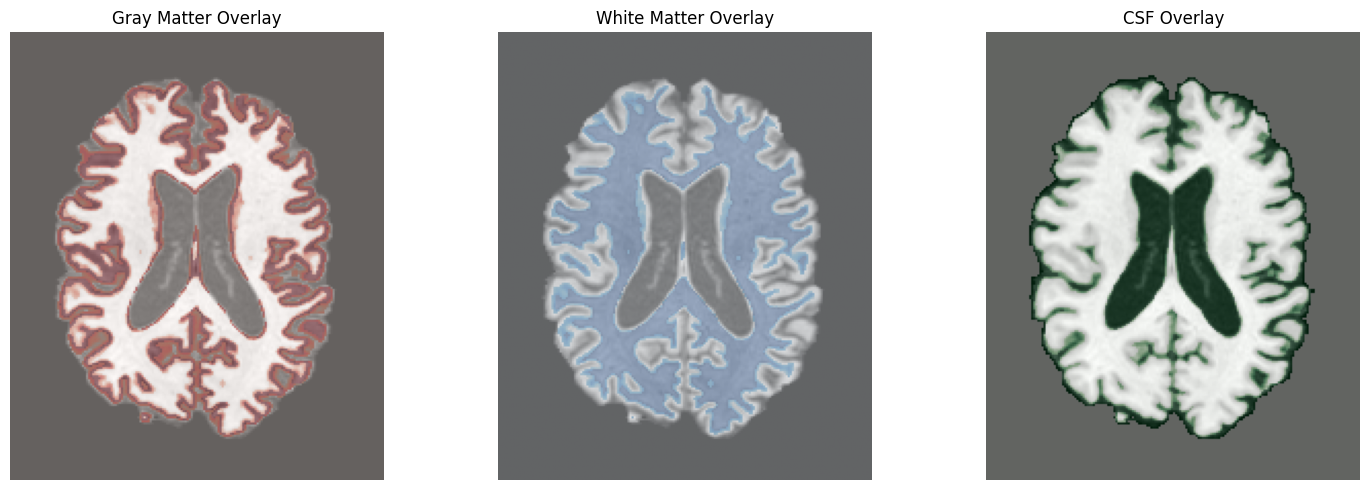

Running FAST on: ADNI_057_S_1379_MR_MPR__GradWarp__B1_Correction__N3_Br_20090514102741022_S66418_I143809_registered.nii.gz
Running FAST on: ADNI_127_S_0393_MR_MPR__GradWarp__B1_Correction__N3_Br_20080123091916004_S22874_I88085_registered.nii.gz
Running FAST on: ADNI_141_S_0767_MR_MPR__GradWarp__B1_Correction__N3_Br_20081028142444542_S57038_I124343_registered.nii.gz


In [40]:
output_dir = fast_dir
os.makedirs(output_dir, exist_ok=True)

files = [f for f in os.listdir(flirt_dir) if f.endswith("_registered.nii.gz")]

first_done = False

for filename in files:
    input_file = os.path.join(flirt_dir, filename)
    base_name = filename.replace("_registered.nii.gz", "")
    out_prefix = os.path.join(output_dir, base_name + "_fast")

    print(f"Running FAST on: {filename}")
    
    # Run FAST segmentation
    fast(input_file, out=out_prefix)

    # Only visualize the first file - changeable
    if not first_done:
        first_done = True

        img = nib.load(input_file).get_fdata()
        mid_slice = img.shape[2] // 2
        base_slice = img[:, :, mid_slice]

        gm = nib.load(out_prefix + "_pve_1.nii.gz").get_fdata()[:, :, mid_slice]
        wm = nib.load(out_prefix + "_pve_2.nii.gz").get_fdata()[:, :, mid_slice]
        csf = nib.load(out_prefix + "_pve_0.nii.gz").get_fdata()[:, :, mid_slice]

        plt.figure(figsize=(15, 5))

        # Gray Matter
        plt.subplot(1, 3, 1)
        plt.imshow(base_slice.T, cmap='gray', origin='lower')
        plt.imshow(gm.T, cmap='Reds', alpha=0.4, origin='lower')
        plt.title("Gray Matter Overlay")
        plt.axis('off')

        # White Matter
        plt.subplot(1, 3, 2)
        plt.imshow(base_slice.T, cmap='gray', origin='lower')
        plt.imshow(wm.T, cmap='Blues', alpha=0.4, origin='lower')
        plt.title("White Matter Overlay")
        plt.axis('off')

        # CSF
        plt.subplot(1, 3, 3)
        plt.imshow(base_slice.T, cmap='gray', origin='lower')
        plt.imshow(csf.T, cmap='Greens', alpha=0.4, origin='lower')
        plt.title("CSF Overlay")
        plt.axis('off')

        plt.tight_layout()
        plt.show()
